# Climate Change and Impacts in Africa

According to the [United Nations](https://www.un.org/en/climatechange/what-is-climate-change), Climate change refers to long-term shifts in temperatures and weather patterns. Such shifts can be natural, due to changes in the sun’s activity or large volcanic eruptions. But since the 1800s, **human activities** have been the main driver of climate change, primarily due to the burning of fossil fuels like coal, oil, and gas.

The consequences of climate change now include, among others, intense droughts, water scarcity, severe fires, rising sea levels, flooding, melting polar ice, catastrophic storms, and declining biodiversity.

In this project, I cleaned, combined and analyzed the data to create a report on the state of climate change in Africa. 

## Dataset

*The dataset, IEA-EDGAR CO2, is a component of the EDGAR (Emissions Database for Global Atmospheric Research) Community GHG database version 7.0 (2022) including or based on data from IEA (2021) Greenhouse Gas Emissions from Energy, www.iea.org/statistics, as modified by the Joint Research Centre. The data source was the [EDGARv7.0_GHG website](https://edgar.jrc.ec.europa.eu/dataset_ghg70) provided by Crippa *et. al.* (2022) and with [DOI](https://data.europa.eu/doi/10.2904/JRC_DATASET_EDGAR).*

The dataset contains three sheets - `IPCC 2006`, `1PCC 1996`, and `TOTALS BY COUNTRY` on the amount of CO2 (a greenhouse gas) generated by countries between 1970 and 2021. 

### TOTALS BY COUNTRY SHEET

This sheet contains the annual CO2 (kt) produced between 1970 - 2021 in each country. The relevant columns in this sheet are:

| Columns | Description |
| ------- | ------------|
| `C_group_IM24_sh` | The region of the world |
| `Country_code_A3` | The country code |
| `Name`            | The name of the country |
| `Y_1970 - Y_2021` | The amount of CO2 (kt) from 1970 - 2021 |


### IPCC 2006

These sheets contain the amount of CO2 by country and the industry responsible. 

| Columns | Description |
| ------- | ------------|
| `C_group_IM24_sh` | The region of the world |
| `Country_code_A3` | The country code |
| `Name`            | The name of the country |
| `Y_1970 - Y_2021` | The amount of CO2 (kt) from 1970 - 2021 |
| `ipcc_code_2006_for_standard_report_name` | The industry responsible for generating CO2 |

## Project Focus


1. Clean and tidy the datasets. 
2. Create a line plot to show the trend of `CO2` levels across the African regions.
3. Determine the relationship between time (`Year`) and `CO2` levels across the African regions.
4. Determine if there is a significant difference in the `CO2` levels among the African Regions.
5. Determine the most common (top 5) industries in each African region.
6. Determine the industry responsible for the most amount of CO2 (on average) in each African Region.
7. Predict the `CO2` levels (at each African region) in the year 2025.
8. Determine if `CO2` levels affect annual `temperature` in the selected African countries.

In [51]:
# libraries
import pandas as pd
import numpy as np
import pingouin
from sklearn.linear_model import LinearRegression
from statsmodels.regression.linear_model import OLS
import seaborn as sns
import matplotlib.pyplot as plt
import inspect

plt.style.use('ggplot')
# The sheet names containing the datasets
sheet_names = ['IPCC 2006', 'TOTALS BY COUNTRY']

# The column names of the dataset starts from rows 11 so I will skip the first 10 rows
datasets = pd.read_excel('IEA_EDGAR_CO2_1970-2021.xlsx', sheet_name = sheet_names, skiprows = 10)

# African regions
african_regions = ['Eastern_Africa', 'Western_Africa', 'Southern_Africa', 'Northern_Africa']

ipcc_2006_africa = datasets['IPCC 2006'].query('C_group_IM24_sh in @african_regions')

totals_by_country_africa = datasets['TOTALS BY COUNTRY'].query('C_group_IM24_sh in @african_regions')


# temperatures datasets containing four African countries
# Nigeria:    West Africa
# Ethiopa :   East Africa
# Tunisia:    North Africa
# Mozambique: South Africa
temperatures = pd.read_csv('temperatures.csv')

## Cleaning the datasets

In [52]:
ipcc_2006_africa.rename(columns={"C_group_IM24_sh" : "Region", "Country_code_A3" : "Code", "ipcc_code_2006_for_standard_report_name": "Industry"}, inplace=True)
totals_by_country_africa.rename(columns={"C_group_IM24_sh" : "Region", "Country_code_A3" : "Code"}, inplace=True)

ipcc_2006_africa.drop(columns = ["IPCC_annex", "ipcc_code_2006_for_standard_report", "Substance"], inplace = True)
totals_by_country_africa.drop(columns = ["IPCC_annex", "Substance"], inplace=True)

ipcc_2006_africa = pd.melt(ipcc_2006_africa, id_vars = ["Region", "Code", "Name", "Industry", "fossil_bio"], var_name = "Year", value_name = "CO2")
totals_by_country_africa = pd.melt(totals_by_country_africa, id_vars=["Region", "Code", "Name"],var_name="Year", value_name="CO2")

ipcc_2006_africa.dropna(subset = ["CO2"], inplace=True)
totals_by_country_africa.dropna(subset = ["CO2"], inplace=True)

ipcc_2006_africa["Year"] = ipcc_2006_africa["Year"].str.replace("Y_", "")
totals_by_country_africa["Year"] = totals_by_country_africa["Year"].str.replace("Y_", "")
ipcc_2006_africa["Year"] = ipcc_2006_africa["Year"].astype(int)
totals_by_country_africa["Year"] = totals_by_country_africa["Year"].astype(int)

In [53]:
ipcc_2006_africa.head()

,Region,Code,Name,Industry,fossil_bio,Year,CO2
0,Southern_Africa,AGO,Angola,Manufacturing Industries and Construction,bio,1970,468.101210
1,Southern_Africa,AGO,Angola,Residential and other sectors,bio,1970,9803.605447
3,Southern_Africa,AGO,Angola,Emissions from biomass burning,bio,1970,1168.997514
4,Southern_Africa,AGO,Angola,Main Activity Electricity and Heat Production,fossil,1970,137.584287
5,Southern_Africa,AGO,Angola,Petroleum Refining - Manufacture of Solid Fuel...,fossil,1970,74.805080


In [54]:
totals_by_country_africa.head()

,Region,Code,Name,Year,CO2
0,Southern_Africa,AGO,Angola,1970,20393.274068
1,Eastern_Africa,BDI,Burundi,1970,4385.562636
2,Western_Africa,BEN,Benin,1970,4318.786819
3,Western_Africa,BFA,Burkina Faso,1970,8158.106987
4,Southern_Africa,BWA,Botswana,1970,947.246888


In [55]:
totals_by_country_africa.sample(10)

,Region,Code,Name,Year,CO2
2102,Western_Africa,MLI,Mali,2007,9556.821404
1227,Southern_Africa,TZA,Tanzania_United Republic of,1991,32048.498641
1460,Southern_Africa,BWA,Botswana,1996,5615.316415
1946,Western_Africa,SHN,Saint Helena,2004,9.090511
377,Western_Africa,SEN,Senegal,1976,4743.624284
1509,Southern_Africa,ZAF,South Africa,1996,410850.250804
2287,Eastern_Africa,SYC,Seychelles,2010,989.432445
917,Western_Africa,GMB,Gambia,1986,600.575915
2276,Western_Africa,NER,Niger,2010,11576.824499
358,Western_Africa,GNB,Guinea-Bissau,1976,1406.456180


## Trend of `CO2` levels across the African regions

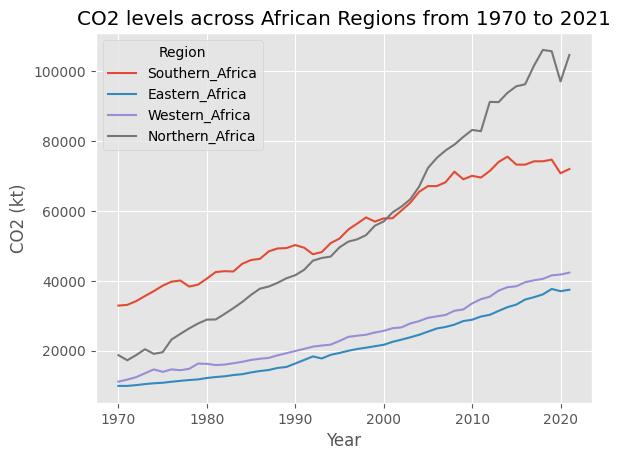

In [56]:
sns.lineplot(x = "Year", y = "CO2", hue = "Region", data = totals_by_country_africa, ci = None)
plt.ylabel('CO2 (kt)')
plt.title('CO2 levels across African Regions from 1970 to 2021')
plt.show()


## Relationship between time (`Year`) and `CO2` levels across the African regions

In [57]:
relationship_btw_time_CO2 = totals_by_country_africa.groupby(["Region"])["Year", "CO2"].corr(method = "spearman")
relationship_btw_time_CO2

Year       CO2
Region                                  
Eastern_Africa  Year  1.000000  0.181768
                CO2   0.181768  1.000000
Northern_Africa Year  1.000000  0.429875
                CO2   0.429875  1.000000
Southern_Africa Year  1.000000  0.260986
                CO2   0.260986  1.000000
Western_Africa  Year  1.000000  0.324071
                CO2   0.324071  1.000000

## Determining if there is a significant difference in the CO2 levels among the African Regions

In [58]:
aov_results = pingouin.anova(data = totals_by_country_africa, dv="CO2", between="Region")
pw_ttest_result = pingouin.pairwise_tests(data=totals_by_country_africa, dv="CO2", between="Region", padjust="bonf")
aov_results
pw_ttest_result

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,Region,Eastern_Africa,Northern_Africa,False,True,-9.435557,388.384101,two-sided,3.637966e-19,2.182780e-18,bonf,1.554e+17,-0.801390
1,Region,Eastern_Africa,Southern_Africa,False,True,-6.814718,641.441785,two-sided,2.180575e-11,1.308345e-10,bonf,4.024e+08,-0.421846
2,Region,Eastern_Africa,Western_Africa,False,True,-1.556846,1917.149304,two-sided,1.196721e-01,7.180324e-01,bonf,0.173,-0.059094
3,Region,Northern_Africa,Southern_Africa,False,True,0.080513,881.040358,two-sided,9.358475e-01,1.000000e+00,bonf,0.079,0.004785
4,Region,Northern_Africa,Western_Africa,False,True,7.588964,567.964972,two-sided,1.328970e-13,7.973818e-13,bonf,9.641e+10,0.418029
5,Region,Southern_Africa,Western_Africa,False,True,5.720995,795.803852,two-sided,1.499036e-08,8.994214e-08,bonf,5.437e+05,0.335300


## Most common (top 5) industries in each African region.

In [59]:
region_grouped = ipcc_2006_africa.groupby(["Region", "Industry"]).size().reset_index(name = "Count").sort_values(["Region", "Count"], ascending= [True, False])
top_5_industries = region_grouped.groupby("Region").head(5).reset_index(drop=True)
top_5_industries

,Region,Industry,Count
0,Eastern_Africa,Residential and other sectors,1454
1,Eastern_Africa,Manufacturing Industries and Construction,1383
2,Eastern_Africa,Main Activity Electricity and Heat Production,1174
3,Eastern_Africa,Road Transportation no resuspension,742
4,Eastern_Africa,Glass Production,728
5,Northern_Africa,Residential and other sectors,572
6,Northern_Africa,Manufacturing Industries and Construction,456
7,Northern_Africa,Main Activity Electricity and Heat Production,315
8,Northern_Africa,Glass Production,312
9,Northern_Africa,Non-Energy Products from Fuels and Solvent Use,312


## Industry responsible for the most amount of CO2 (on average) in each African Region

In [60]:
group_region = ipcc_2006_africa.groupby(["Region", "Industry"])["CO2"].mean().reset_index()
max_co2_industries = group_region.loc[group_region.groupby("Region")["CO2"].idxmax().reset_index(drop=True)]
max_co2_industries

,Region,Industry,CO2
18,Eastern_Africa,Residential and other sectors,7904.439282
31,Northern_Africa,Main Activity Electricity and Heat Production,13612.230148
54,Southern_Africa,Main Activity Electricity and Heat Production,11377.802504
87,Western_Africa,Residential and other sectors,8702.936136


## Predicting the `CO2` levels (at each African region) in the year 2025

In [61]:
newdata = pd.DataFrame({ 'Year': 2025, 'Region': african_regions })
newdata = pd.get_dummies(newdata)

reg = LinearRegression()

lin_fit = np.log10(totals_by_country_africa["CO2"])

features = pd.get_dummies(totals_by_country_africa[["Year", "Region"]])

reg.fit(features, lin_fit)

predicted_co2 = reg.predict(newdata)

predicted_co2 = np.round(10**predicted_co2, 2)

In [62]:
predicted_co2

array([15177.72, 10788.07, 37761.69, 41081.9 ])

## Determine if CO2 levels affect annual temperature in the selected African countries

In [63]:
countries = ["Ethiopia", "Mozambique", "Nigeria", "Tunisia"]

selected_countries = totals_by_country_africa[["Name","Year","CO2"]]
[totals_by_country_africa["Name"].isin(countries)]

temp_long = pd.melt(temperatures, id_vars = "Year", var_name = "Name", value_name = "Temperature" )

joined = pd.merge(selected_countries, temp_long, on=["Name", "Year"], how= "inner")

model_temp = OLS.from_formula("Temperature ~ np.log10(CO2) + Name", data = joined).fit()
model_temp.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Temperature   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                     3241.
Date:                Thu, 25 Jan 2024   Prob (F-statistic):          1.22e-182
Time:                        14:13:36   Log-Likelihood:                -54.347
No. Observations:                 208   AIC:                             118.7
Df Residuals:                     203   BIC:                             135.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             13.4981      0.583     23.138      0.000      12.348      14.648
Name[T.Mozambique]     2.0759      0.090     23.021      0.000       1.898       2.254
Name[T.Nigeria]        2.8345      0.092     30.884      0.000       2.654       3.016
Name[T.Tunisia]       -1.6254      0.104    -15.673      0.000      -1.830      -1.421
np.log10(CO2)          1.9472      0.117     16.620      0.000       1.716       2.178
==============================================================================
Omnibus:                        3.230   Durbin-Watson:                   1.896
Prob(Omnibus):                  0.199   Jarque-Bera (JB):                2.985
Skew:                          -0.291   Prob(JB):                        0.225
Kurtosis:                       3.073   Cond. No.                         136.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""